# 0. IMPORT PACKAGES & DATASET

In [2]:
import pandas as pd 
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_columns', 100)
# pd.set_option('display.max_rows', None)  # Show all rows
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

from lightgbm import LGBMClassifier, early_stopping
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from scipy.stats import uniform, randint
import shap

import joblib

In [3]:
df = pd.read_parquet("loan_final.parquet")

In [4]:
# Drop columns due to possible data leakage or missing values (>60%) or noisy 
cols_to_drop = [
    'annual_inc_joint', 'verification_status_joint', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc',
    'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'last_credit_pull_d', 'mths_since_last_record', 'mths_since_last_major_derog',
    'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 
    'dti_joint', 'revol_bal_joint', 'url', 'desc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 
    'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'policy_code', 'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status', 
    'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status',
    'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'debt_settlement_flag_date', 'settlement_status', 
    'settlement_date', 'settlement_amount', 'settlement_percentage', 'settlement_term', 'next_pymnt_d', 'issue_d', 'loan_status', 'title', 'emp_title', 'addr_state', 
    'zip_code', 'earliest_cr_line'
]
df = df.drop(columns=cols_to_drop)
print(df.shape)
df.head()

(2260668, 84)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,pymnt_plan,purpose,initial_list_status,disbursement_method,debt_settlement_flag,snapshot_date,emp_length,home_ownership,annual_inc,verification_status,application_type,mort_acc,num_tl_op_past_12m,inq_last_6mths,inq_last_12m,inq_fi,mths_since_last_delinq,mths_since_recent_inq,mths_since_rcnt_il,mths_since_recent_bc,acc_now_delinq,delinq_2yrs,pub_rec,collections_12_mths_ex_med,chargeoff_within_12_mths,tax_liens,pub_rec_bankruptcies,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_accts_ever_120_pd,delinq_amnt,dti,revol_bal,revol_util,total_rev_hi_lim,tot_coll_amt,tot_cur_bal,avg_cur_bal,all_util,max_bal_bc,il_util,bc_util,total_bal_il,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,tot_hi_cred_lim,open_acc,total_acc,open_acc_6m,open_act_il,open_il_12m,open_il_24m,open_rv_12m,open_rv_24m,acc_open_past_24mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,num_actv_bc_tl,num_actv_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_il_tl,num_bc_tl,num_op_rev_tl,num_sats,num_bc_sats,total_cu_tl,bc_open_to_buy,percent_bc_gt_75,pct_tl_nvr_dlq
0,LOAN_1653274,MEM_931131,6000,6000,6000.0,36 months,8.39,189.10,A,A5,n,credit_card,f,Cash,N,2022-01-01,< 1 year,RENT,48000.0,Not Verified,Individual,0.0,0.0,0.0,NaN,NaN,19.0,13.0,NaN,17.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,18.98,6151,39.4,15600.0,0.0,41018.0,6836.0,NaN,NaN,NaN,45.2,NaN,41018.0,13600.0,40773.0,56373.0,6.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,6.0,90.0,86.0,17.0,13.0,1.0,1.0,8.0,1.0,11.0,6.0,5.0,6.0,4.0,NaN,7449.0,25.0,85.0
1,LOAN_812253,MEM_1111718,35000,35000,35000.0,60 months,20.99,946.68,E,E4,n,debt_consolidation,f,Cash,N,2022-01-01,< 1 year,MORTGAGE,110000.0,Verified,Individual,3.0,1.0,1.0,NaN,NaN,67.0,3.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,11.27,4093,40.5,10100.0,59.0,153530.0,21933.0,NaN,NaN,NaN,NaN,NaN,49839.0,0.0,57417.0,186222.0,8.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,141.0,189.0,31.0,3.0,0.0,2.0,6.0,2.0,6.0,3.0,3.0,8.0,0.0,NaN,NaN,NaN,87.5
2,LOAN_2156025,MEM_545144,15000,15000,15000.0,36 months,7.49,466.53,A,A4,n,credit_card,w,Cash,N,2022-01-01,2 years,RENT,95000.0,Not Verified,Individual,1.0,3.0,0.0,2.0,0.0,7.0,10.0,7.0,10.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.09,34397,44.7,76900.0,0.0,88183.0,4409.0,63.0,15084.0,86.0,50.7,53786.0,88183.0,63000.0,62783.0,139683.0,21.0,29.0,0.0,4.0,2.0,4.0,1.0,2.0,6.0,128.0,298.0,10.0,7.0,7.0,12.0,22.0,12.0,6.0,14.0,17.0,21.0,10.0,0.0,31060.0,22.2,93.1
3,LOAN_1914224,MEM_196440,7000,7000,7000.0,36 months,10.99,229.14,B,B4,n,debt_consolidation,w,Cash,N,2022-01-01,1 year,RENT,80000.0,Source Verified,Individual,0.0,1.0,1.0,3.0,0.0,NaN,1.0,40.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.89,14258,75.4,18900.0,0.0,21285.0,3041.0,65.0,4224.0,50.0,83.5,7027.0,21285.0,6200.0,14000.0,32900.0,7.0,11.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,53.0,103.0,11.0,11.0,2.0,5.0,8.0,5.0,3.0,4.0,6.0,7.0,3.0,2.0,1020.0,33.3,100.0
4,LOAN_683879,MEM_968196,15600,15600,15600.0,36 months,12.69,523.30,C,C2,n,credit_card,w,Cash,N,2022-01-01,4 years,RENT,50000.0,Not Verified,Individual,0.0,6.0,0.0,NaN,NaN,NaN,12.0,NaN,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.02,19643,77.0,25500.0,0.0,31290.0,2235.0,NaN,NaN,NaN,95.1,NaN,31290.0,17500.0,26208.0,51708.0,15.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,12.0,52.0,90.0,10.0,8.0,5.0,8.0,12.0,8.0,10.0,6.0,12.0,15.0,6.0,NaN,856.0,80.0,100.0


# 1. SPLIT DATA

In [5]:
# Sort by date column 
df = df.sort_values('snapshot_date')

# Define cutoff dates to split into train/val/test 
# Train/val/test: 2022-01-01 to 2024-03-31
# OOT1: 2024-04-01 to 2024-06-30
# OOT2: 2024-07-01 to 2024-09-30
# OOT3: 2024-10-01 to 2024-12-31

oot3 = df[(df['snapshot_date'] >= '2024-10-01') & (df['snapshot_date'] <= '2024-12-31')]
oot2 = df[(df['snapshot_date'] >= '2024-07-01') & (df['snapshot_date'] <= '2024-09-30')]
oot1 = df[(df['snapshot_date'] >= '2024-04-01') & (df['snapshot_date'] <= '2024-06-30')]
train_val_test = df[df['snapshot_date'] < '2024-04-01']


In [6]:
X = train_val_test.drop(columns=['id', 'member_id', 'grade', 'sub_grade', 'snapshot_date'])
y = train_val_test['grade']

In [7]:
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.5, random_state=42)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(1185713, 79) (1185713,) (254081, 79) (254081,) (254082, 79) (254082,)


In [8]:
# OOT
X_oot1 = oot1.drop(columns=['id', 'member_id', 'grade', 'sub_grade', 'snapshot_date'])
y_oot1 = oot1['grade']

X_oot2 = oot2.drop(columns=['id', 'member_id', 'grade', 'sub_grade', 'snapshot_date'])
y_oot2 = oot2['grade']

X_oot3 = oot3.drop(columns=['id', 'member_id', 'grade', 'sub_grade', 'snapshot_date'])
y_oot3 = oot3['grade']

# 2. DATA CLEANING & PREPROCESSING

## 2.1 Demographic Features

In [9]:
def clean_demographic_features(df): 
    df['home_ownership'] = df['home_ownership'].fillna('MISSING')
    df['annual_inc'] = df['annual_inc'].fillna(-1)
    df['emp_length'] = df['emp_length'].fillna('MISSING')

    emp_length_map = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10,
    'MISSING': -1  # or use np.nan if you plan to impute
    }
    df['emp_length'] = df['emp_length'].map(emp_length_map)

    df['application_type'] = df['application_type'].map({'Individual': 0, 'Joint App': 1})


    return df 

# X_train = clean_demographic_features(X_train)

## 2.2 Credit History Features

In [10]:
def clean_credit_history_features(df):
    # Fill NA with -1. 
    cols = [
        'mort_acc', 'num_tl_op_past_12m', 'inq_last_12m', 'inq_fi', 'mths_since_last_delinq',
        'mths_since_recent_inq', 'mths_since_rcnt_il', 'mths_since_recent_bc', 'num_tl_120dpd_2m',
        'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_accts_ever_120_pd'
    ]
    df = df.fillna({col: -1 for col in cols})

    # Impute missing values with the mode. 
    cols = [
        'inq_last_6mths', 'acc_now_delinq', 'delinq_2yrs', 'pub_rec', 
        'collections_12_mths_ex_med', 'chargeoff_within_12_mths', 'tax_liens', 'pub_rec_bankruptcies',
        'delinq_amnt'
    ]

    for col in cols:
        df[col] = df[col].fillna(df[col].mode()[0])

    return df

# X_train = clean_credit_history_features(X_train)

## 2.3 Financial Features

In [11]:
def clean_financial_features(df):
    # Impute with mean 
    df['dti'] = df['dti'].fillna(df['dti'].mean())
    
    # Impute with 0
    cols = [
        "revol_util", "total_rev_hi_lim", "tot_coll_amt", "tot_cur_bal", "avg_cur_bal", "all_util", "max_bal_bc", 
        "open_acc", "total_acc", "open_acc_6m", "open_act_il", "open_il_12m", "open_il_24m", "open_rv_12m", "open_rv_24m", 
        "acc_open_past_24mths", "num_actv_bc_tl", "num_actv_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0", "num_il_tl", 
        "num_bc_tl", "num_op_rev_tl", "num_sats", "num_bc_sats", "total_cu_tl"
    ]
    df[cols] = df[cols].fillna(0)

    # Impute it with -1 
    cols = [
        "il_util", "bc_util", "total_bal_il", "total_bal_ex_mort", "total_bc_limit", "total_il_high_credit_limit", 
        "tot_hi_cred_lim", "mo_sin_old_il_acct", "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", 
        "bc_open_to_buy", "percent_bc_gt_75", "pct_tl_nvr_dlq"
    ]
    df = df.fillna({col: -1 for col in cols})

    return df

# X_train = clean_financial_features(X_train)

## 2.4 Loan Terms & Payment Info Features

In [12]:
def clean_loan_terms_and_payment_info_features(df):
    # Convert string values to 0/1 
    binary_cols = ['pymnt_plan', 'debt_settlement_flag', 'initial_list_status', 'disbursement_method']
    df[binary_cols] = df[binary_cols].apply(lambda col: col.str.lower().map({'y': 1, 'n': 0, 'w': 1, 'f': 0, 'cash': 1, 'directpay': 0}))

    # Extract only the months
    df['term'] = df['term'].str.extract(r'(\d+)').astype(int)

    return df

# X_train = clean_loan_terms_and_payment_info_features(X_train)

In [13]:
# # Sanity check for missing values 
# for col in X_train:
#     print(col)
#     print(X_train[col].isna().sum())

## 2.5 Clean & Preprocess

In [14]:
X_train = clean_demographic_features(X_train)
X_train = clean_credit_history_features(X_train)
X_train = clean_financial_features(X_train)
X_train = clean_loan_terms_and_payment_info_features(X_train)

X_val = clean_demographic_features(X_val)
X_val = clean_credit_history_features(X_val)
X_val = clean_financial_features(X_val)
X_val = clean_loan_terms_and_payment_info_features(X_val)

X_test = clean_demographic_features(X_test)
X_test = clean_credit_history_features(X_test)
X_test = clean_financial_features(X_test)
X_test = clean_loan_terms_and_payment_info_features(X_test)

X_oot1 = clean_demographic_features(X_oot1)
X_oot1 = clean_credit_history_features(X_oot1)
X_oot1 = clean_financial_features(X_oot1)
X_oot1 = clean_loan_terms_and_payment_info_features(X_oot1)

X_oot2 = clean_demographic_features(X_oot2)
X_oot2 = clean_credit_history_features(X_oot2)
X_oot2 = clean_financial_features(X_oot2)
X_oot2 = clean_loan_terms_and_payment_info_features(X_oot2)

X_oot3 = clean_demographic_features(X_oot3)
X_oot3 = clean_credit_history_features(X_oot3)
X_oot3 = clean_financial_features(X_oot3)
X_oot3 = clean_loan_terms_and_payment_info_features(X_oot3)

# 3. EXTRA PREPROCESSING FOR RESPECTIVE MODELS

In [15]:
X_train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,pymnt_plan,purpose,initial_list_status,disbursement_method,debt_settlement_flag,emp_length,home_ownership,annual_inc,verification_status,application_type,mort_acc,num_tl_op_past_12m,inq_last_6mths,inq_last_12m,inq_fi,mths_since_last_delinq,mths_since_recent_inq,mths_since_rcnt_il,mths_since_recent_bc,acc_now_delinq,delinq_2yrs,pub_rec,collections_12_mths_ex_med,chargeoff_within_12_mths,tax_liens,pub_rec_bankruptcies,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_accts_ever_120_pd,delinq_amnt,dti,revol_bal,revol_util,total_rev_hi_lim,tot_coll_amt,tot_cur_bal,avg_cur_bal,all_util,max_bal_bc,il_util,bc_util,total_bal_il,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,tot_hi_cred_lim,open_acc,total_acc,open_acc_6m,open_act_il,open_il_12m,open_il_24m,open_rv_12m,open_rv_24m,acc_open_past_24mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,num_actv_bc_tl,num_actv_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_il_tl,num_bc_tl,num_op_rev_tl,num_sats,num_bc_sats,total_cu_tl,bc_open_to_buy,percent_bc_gt_75,pct_tl_nvr_dlq
876556,21000,21000,21000.0,36,19.72,777.45,0,debt_consolidation,0,1,0,10,RENT,56276.0,Verified,0,0.0,0.0,2.0,4.0,4.0,44.0,0.0,13.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.05,5144,51.4,10000.0,0.0,108176.0,18029.0,68.0,4868.0,73.0,97.4,103032.0,108176.0,5000.0,103113.0,113113.0,6.0,31.0,0.0,4.0,0.0,2.0,0.0,1.0,3.0,135.0,32.0,23.0,13.0,1.0,2.0,2.0,2.0,29.0,1.0,2.0,6.0,1.0,3.0,132.0,100.0,92.0
1231439,16000,16000,16000.0,60,7.97,324.20,0,debt_consolidation,0,1,0,0,MORTGAGE,82000.0,Not Verified,1,1.0,1.0,0.0,0.0,0.0,-1.0,13.0,40.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.16,1692,6.9,24400.0,0.0,163837.0,23405.0,44.0,84.0,69.0,0.6,25980.0,27672.0,14400.0,37925.0,210778.0,8.0,24.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,137.0,136.0,9.0,9.0,2.0,3.0,8.0,3.0,15.0,4.0,5.0,8.0,3.0,1.0,14308.0,0.0,100.0
1131787,30000,30000,29900.0,60,13.99,697.90,0,debt_consolidation,0,1,0,1,RENT,192000.0,Source Verified,0,0.0,0.0,0.0,-1.0,-1.0,-1.0,11.0,-1.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.27,24173,86.0,28100.0,0.0,244376.0,22216.0,0.0,0.0,-1.0,86.0,-1.0,244376.0,28100.0,218549.0,246649.0,11.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,123.0,113.0,26.0,15.0,6.0,6.0,9.0,6.0,20.0,9.0,6.0,11.0,6.0,0.0,3927.0,83.3,100.0
505502,10800,10800,10800.0,36,13.44,366.19,0,debt_consolidation,1,1,0,1,MORTGAGE,88000.0,Source Verified,0,4.0,2.0,0.0,2.0,1.0,5.0,9.0,4.0,30.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.20,23070,73.5,31400.0,0.0,549530.0,22897.0,84.0,6576.0,89.0,94.5,138884.0,162502.0,23500.0,164915.0,599509.0,25.0,59.0,1.0,10.0,1.0,3.0,1.0,1.0,5.0,160.0,150.0,9.0,4.0,6.0,9.0,26.0,9.0,28.0,10.0,12.0,25.0,7.0,2.0,1290.0,100.0,96.4
910324,10800,10800,10775.0,60,13.99,251.25,0,credit_card,0,1,0,10,RENT,51500.0,Not Verified,0,0.0,1.0,1.0,-1.0,-1.0,26.0,5.0,-1.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.18,11167,72.7,15356.0,0.0,11167.0,1861.0,0.0,0.0,-1.0,96.6,-1.0,11167.0,11556.0,0.0,15356.0,8.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,125.0,211.0,9.0,9.0,3.0,3.0,26.0,3.0,1.0,17.0,8.0,8.0,4.0,0.0,389.0,75.0,100.0


In [16]:
# Standard Scaling 
# loan_amnt, funded_amnt, funded_amnt_inv, term, int_rate, installment, emp_length
# annual_inc, mort_acc, num_tl_op_past_12m, inq_last_6mths, inq_last_12m, inq_fi,
# mths_since_last_delinq, mths_since_recent_inq, mths_since_rcnt_il, mths_since_recent_bc,
# acc_now_delinq, delinq_2yrs, pub_rec, collections_12_mths_ex_med, chargeoff_within_12_mths
# tax_liens, pub_rec_bankruptcies, num_tl_120dpd_2m, num_tl_30dpd, num_tl_90g_dpd_24m, 
# num_accts_ever_120_pd, delinq_amnt, dti, revol_bal, revol_util, total_rev_hi_lim, tot_coll_amt
# tot_cur_bal, avg_cur_bal and the rest. 

# One-hot encoding
# purpose, home_ownership, verification_status, 

# Binary 
# pymnt_plan, initial_list_status, disbursement_method, debt_settlement_flag, application_type

X_train.avg_cur_bal.value_counts(dropna=False)
# X_train.loan_status.info()

avg_cur_bal
0.0        37277
2542.0       177
2442.0       165
2750.0       164
2758.0       161
           ...  
80002.0        1
53364.0        1
57824.0        1
71695.0        1
66912.0        1
Name: count, Length: 68863, dtype: int64

## 3.1 Label

LightGBM requires numerical labels for multiclass classification.

In [17]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)
y_oot1 = label_encoder.transform(y_oot1)
y_oot2 = label_encoder.transform(y_oot2)
y_oot3 = label_encoder.transform(y_oot3)

## 3.2 Features

In [18]:
datasets = {
    "train": X_train,
    "val": X_val,
    "test": X_test,
    "oot1": X_oot1,
    "oot2": X_oot2,
    "oot3": X_oot3,
}

for name, df in datasets.items():
    # convert categorical features to category data type
    # Since LightGBM can handle categorical features natively, there is no need to do one-hot encoding. Only need to convert it to category data type
    categorical_cols = ['term', 'pymnt_plan', 'purpose', 'initial_list_status', 'disbursement_method', 'debt_settlement_flag', 'home_ownership', 'verification_status', 'application_type']
    for col in categorical_cols:
        df[col] = df[col].astype('category')

    
    # no need to do normalization since LightGBM is a tree based model

    datasets[name] = df

X_train = datasets["train"]
X_val = datasets["val"]
X_test = datasets["test"]
X_oot1 = datasets["oot1"]
X_oot2 = datasets["oot2"]
X_oot3 = datasets["oot3"]

# 4. Early Stopping

## 4.1 Training

In [19]:
model = LGBMClassifier(
    objective='multiclass',
    random_state=42,
    class_weight='balanced'
)

model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='multi_logloss',
    callbacks=[early_stopping(stopping_rounds=50)],
)

joblib.dump(model, 'lgbm_classifier_base.pkl')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8825
[LightGBM] [Info] Number of data points in the train set: 1185713, number of used features: 79
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.117721


['lgbm_classifier_base.pkl']

## 4.2 Evaluation

In [19]:
def evaluate_model(model, X, y_true, dataset_name):
    y_pred_labels = model.predict(X)  # directly returns predicted labels

    f1 = f1_score(y_true, y_pred_labels, average='weighted')
    precision = precision_score(y_true, y_pred_labels, average=None)
    recall = recall_score(y_true, y_pred_labels, average=None)
    cm = confusion_matrix(y_true, y_pred_labels)

    print(f"\n{dataset_name} Evaluation:")
    print(f"F1 Score: {f1:.4f}")
    print(f"Per-class Precision: {precision}")
    print(f"Per-class Recall: {recall}")
    print("Confusion Matrix:\n", cm)

    return {
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "confusion_matrix": cm
    }

In [20]:
# evaluate on all datasets
results = {}
for name, X, y in [
    ('Train', X_train, y_train),
    ('Validation', X_val, y_val),
    ('Test', X_test, y_test),
    ('OOT1', X_oot1, y_oot1),
    ('OOT2', X_oot2, y_oot2),
    ('OOT3', X_oot3, y_oot3),
]:
    results[name] = evaluate_model(model, X, y, name)


Train Evaluation:
F1 Score: 0.9529
Per-class Precision: [0.98699124 0.97066152 0.97458933 0.91818696 0.81503207 0.80153396
 0.75843869]
Per-class Recall: [0.99536455 0.9751586  0.943002   0.90599692 0.87726576 0.89329044
 0.97892902]
Confusion Matrix:
 [[226324   1050      2      1      0      1      0]
 [  2910 339716   5699     39      0      5      1]
 [    37   9187 321211  10092     89      9      1]
 [    33     31   2561 154159  13103    239     28]
 [     3      0    112   3537  62385   4460    616]
 [     0      0      1     64    935  19438   1322]
 [     0      0      0      3     31     99   6179]]

Validation Evaluation:
F1 Score: 0.9502
Per-class Precision: [0.98562307 0.96946055 0.97259693 0.91692624 0.80881722 0.77385892
 0.6906924 ]
Per-class Recall: [0.99370592 0.9730875  0.94403118 0.90502073 0.86368101 0.85550459
 0.88832117]
Confusion Matrix:
 [[48469   305     1     0     0     1     0]
 [  672 72568  1321    10     0     4     0]
 [   18  1959 68784  2069    30 

## 4.3 SHAP

In [ ]:
# SHAP
explainer = shap.TreeExplainer(model)

In [27]:
shap_obj = explainer(X_test)

In [25]:
shap_values = explainer.shap_values(X_test)

C:\Users\m1769\AppData\Local\Temp\ipykernel_11520\3494531848.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10)


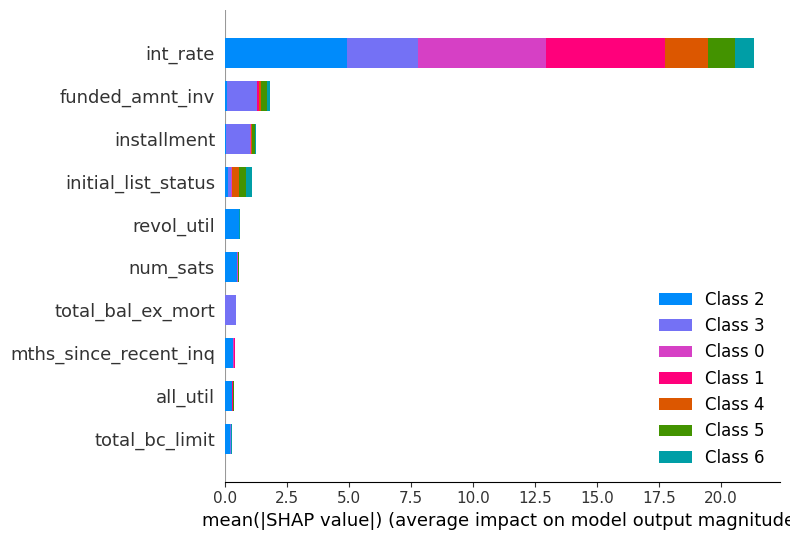

In [36]:
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10)

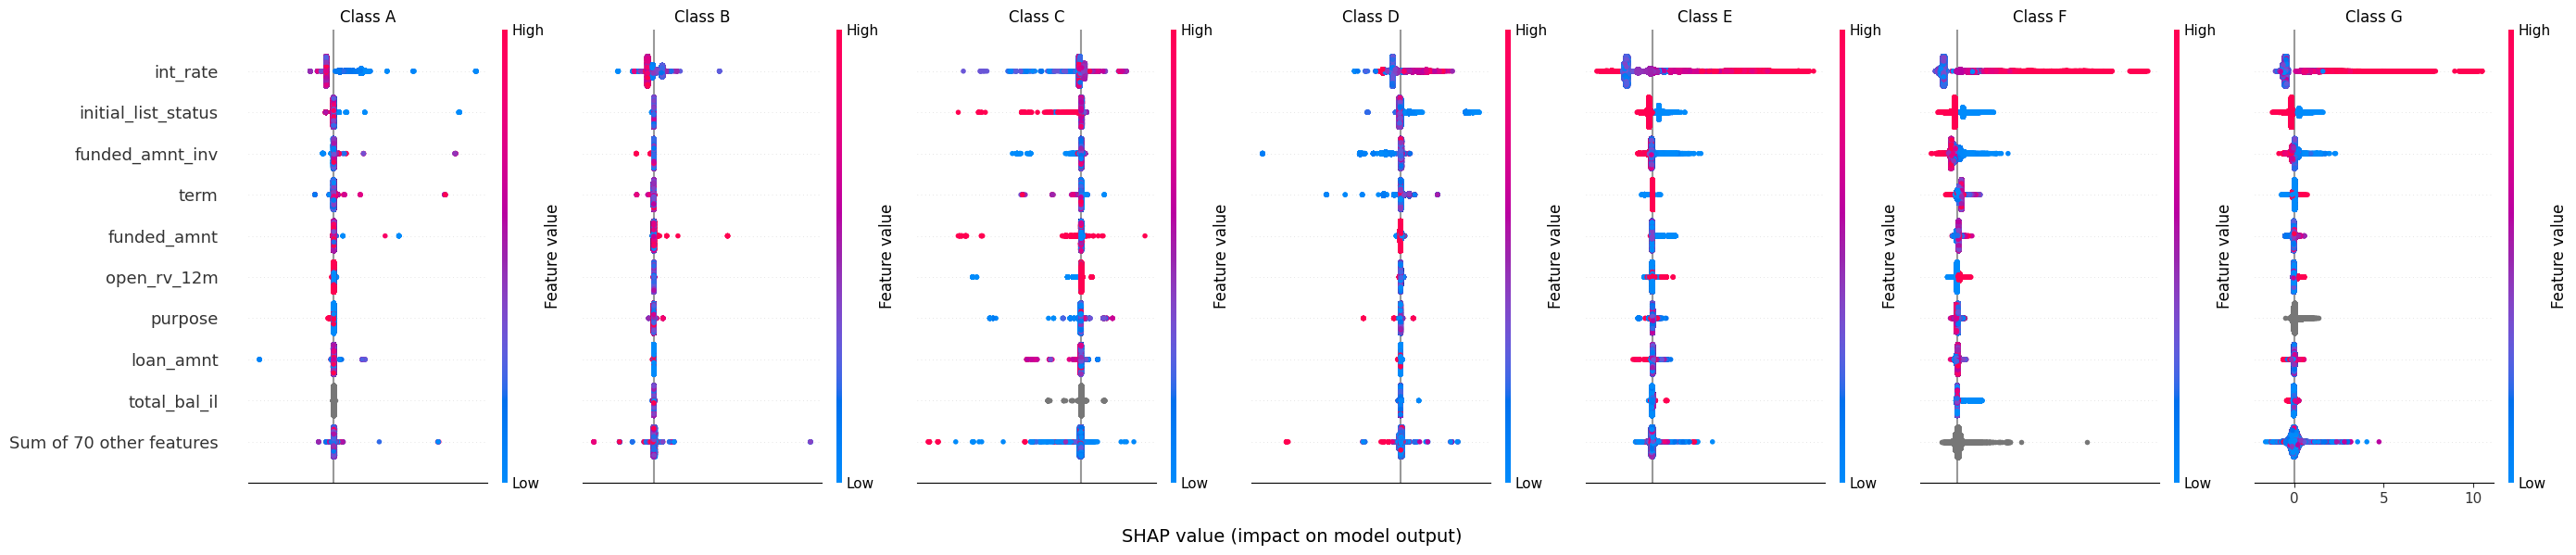

In [ ]:
# define class labels A to G
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

n_classes = shap_obj.values.shape[2]
fig, axes = plt.subplots(1, n_classes, figsize=(4 * n_classes, 6), sharey=True)

for i in range(n_classes):
    ax = axes[i]
    shap.plots.beeswarm(shap_obj[..., i], max_display=10, show=False, ax=ax, plot_size=None)
    ax.set_title(f"Class {class_names[i]}", fontsize=12)
    if i != 0:
        ax.set_ylabel("")
    ax.set_xlabel("")
    if i != n_classes - 1:
        ax.set_xticklabels([])
        ax.set_xticks([])

fig.supxlabel("SHAP value (impact on model output)", fontsize=14)

for cb in fig.get_axes():
    if cb.get_position().x0 > 0.90:
        cb.remove()

plt.tight_layout()
plt.show()

In [26]:
# show top 5 features
mean_abs_shap = np.mean(np.abs(shap_values), axis=(0, 2))

shap_df = pd.DataFrame({
    'feature': X_test.columns,
    'mean_abs_shap': mean_abs_shap
})
top5 = shap_df.sort_values('mean_abs_shap', ascending=False).head(5)
print(top5)

                feature  mean_abs_shap
4              int_rate       3.044301
2       funded_amnt_inv       0.258796
5           installment       0.178704
8   initial_list_status       0.158004
39           revol_util       0.085802


# 5. Fine-tuning

## 5.1 Model Training

In [ ]:
# parameter space
param_dist = {
    'num_leaves': randint(20, 60),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.03, 0.1),
    'n_estimators': randint(100, 300),
    'subsample': uniform(0.8, 0.2),
    'colsample_bytree': uniform(0.8, 0.2)
}

fit_params = {
    'eval_set': [(X_val, y_val)],
    'eval_metric': 'multi_logloss',
    'callbacks': [early_stopping(stopping_rounds=50)],
}

In [ ]:
model = LGBMClassifier(
    objective='multiclass',
    random_state=42,
    class_weight='balanced',
    verbosity=-1
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    scoring='f1_macro',
    cv=cv,
    n_iter=50,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

In [ ]:
random_search.fit(X_train, y_train, categorical_feature=categorical_cols, **fit_params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[257]	valid_0's multi_logloss: 0.108286


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=LGBMClassifier(class_weight='balanced',
                                            objective='multiclass',
                                            random_state=42, verbosity=-1),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000282D453B5B0>,
                                        'learning_rate': <scipy.sta...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000282D453B250>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000282D453B100>,
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000282D452A490>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000282D09E2BE0>},
                   random_state=42, scoring='f1_macro', verbose=2)

In [ ]:
best_model = random_search.best_estimator_
print("Best parameters found:")
print(random_search.best_params_)

Best parameters found:
{'colsample_bytree': 0.901762815367752, 'learning_rate': 0.09363326181858954, 'max_depth': 8, 'n_estimators': 257, 'num_leaves': 57, 'subsample': 0.9957785716550018}


## 5.2 Evaluation

In [ ]:
results = {}
for name, X, y in [
    ('Train', X_train, y_train),
    ('Validation', X_val, y_val),
    ('Test', X_test, y_test),
    ('OOT1', X_oot1, y_oot1),
    ('OOT2', X_oot2, y_oot2),
    ('OOT3', X_oot3, y_oot3),
]:
    results[name] = evaluate_model(best_model, X, y, name)


Train Evaluation:
F1 Score: 0.9665
Per-class Precision: [0.99437747 0.98131088 0.97955702 0.93461454 0.85769983 0.87859887
 0.93358971]
Per-class Recall: [0.9987026  0.98240664 0.95586655 0.92574374 0.92496449 0.97748162
 1.        ]
Confusion Matrix:
 [[227083    295      0      0      0      0      0]
 [  1259 342241   4870      0      0      0      0]
 [    23   6222 325593   8739     48      1      0]
 [     2      1   1901 157519  10576    151      4]
 [     0      0     24   2275  65777   2787    250]
 [     0      0      0      6    289  21270    195]
 [     0      0      0      0      0      0   6312]]

Validation Evaluation:
F1 Score: 0.9522
Per-class Precision: [0.98685176 0.97140024 0.97031358 0.91902744 0.81829306 0.79569892
 0.75488918]
Per-class Recall: [0.99251681 0.97193429 0.94832697 0.91100497 0.87572841 0.86405338
 0.84525547]
Confusion Matrix:
 [[48411   363     1     0     1     0     0]
 [  607 72482  1479     5     2     0     0]
 [   18  1755 69097  1962    30 